In [6]:
from moviepy.editor import *
import cv2
import numpy as np
import pandas as pd
import os 
import shutil
import math
from matplotlib import pyplot as plt
from pydub import AudioSegment
import tensorflow as tf
import librosa
import soundfile
from datetime import date
from datetime import datetime
%matplotlib inline
import seaborn as sns
from pickle import load
import librosa.display
# from tensorflow import keras
import keras

In [7]:
def show(img, titlestr=""):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray') #if not specified, it will treat this image as heat map
    else:
        plt.imshow(img)
    plt.xticks([]), plt.yticks([])  
    plt.title(titlestr)
    plt.show() 

In [8]:
def loadModels():
    # Load the cascade
    faceDetector = cv2.dnn.readNetFromCaffe(os.path.join('Program','Models','deploy.prototxt.txt'),os.path.join('Program','Models','res10_300x300_ssd_iter_140000.caffemodel'))
    
    # Face model
    loaded_model_face = keras.models.load_model(os.path.join('Program','Models','faceModel629-self.h5'))
    
    # Voice model
    loaded_model_voice = keras.models.load_model(os.path.join('Program','Models','voiceModel-aug-mel823.h5'))
    
    # load the scaler
    scaler = load(open(os.path.join('Program','Models','scaler.pkl'), 'rb'))
    
    return faceDetector,loaded_model_face,loaded_model_voice,scaler

def extractFrames(path):
    video = cv2.VideoCapture(path)
    
    frameRate = video.get(5) #frame rate
    extractedFrames = []

    while(video.isOpened()):
        frameId = video.get(1) #current frame number
        ret, frame = video.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0): #every second save the first frame
            rgbImage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            extractedFrames.append(rgbImage)

    video.release()

    return extractedFrames

def extractAudio(path):
    destinationFolder = 'Extracted audio'
    destAudio = os.path.join(destinationFolder,'audio.wav')
    
    # Create directory if no such directory
    if not os.path.exists(destinationFolder):
        os.makedirs(destinationFolder)
    
    # Extract audio from the video
    video = VideoFileClip(path)
    video.audio.write_audiofile(destAudio, logger=None)
    video.close()
    
    # Delete the video
#     os.remove(path)
#     
    # Convert to mono channel
    sound = AudioSegment.from_wav(destAudio)
    sound = sound.set_channels(1)
    
    # Extract audio for every 3 seconds
    length = int(sound.duration_seconds)    
    num = int(length/3)
    audioList = []
    
    for i in range(num):
        dest = os.path.join(destinationFolder,str(i+1)+'.wav')
        crop_file = sound[(i*3)*1000:]
        crop_file.export(dest, format='wav')
        
        # Read in again with desired format and library
        X, sample_rate = librosa.load(dest, duration=3, res_type='kaiser_fast',sr=44100,offset=0.5)
        audioList.append(X)

    # Delete the directory and the audio inside it
    if os.path.exists(destinationFolder):
        shutil.rmtree(destinationFolder)
    
    return audioList, sample_rate

def getCroppedFaceRegions(frames,faceDetector):
    cropped = []
    
    for frame in frames:
        # Detect faces
        h, w = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
        faceDetector.setInput(blob)
        faces = faceDetector.forward()

        try:
            for i in range(faces.shape[2]):
                confidence = faces[0, 0, i, 2]
                if confidence > 0.7:
                    box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (x1, y1, x2, y2) = box.astype("int")
                    face_rgb = frame[y1:y2,x1:x2]
#                     show(frame)
#                     show(face_rgb)
                    cropped.append(cv2.resize(face_rgb,(48,48)))

        except cv2.error as e:
            print('[Unknown error] Invalid face!')
        
    return cropped

def faceRecog(faces,model):
    result = []
    
    for face in faces:
        img = face.astype('float32') / 255.0
        img = img.reshape(-1, 48, 48, 1)
        result.append(model.predict(img)[0])
    
    faceTotal = len(result)
    finalFaceResult = []
    
    #calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalFaceResult.append(sumEmotion/faceTotal)
    
    # Round up to 4 decimal places
    finalFaceResult = [np.round(num, 4) for num in finalFaceResult]
    
    return finalFaceResult

def getMelSpect(audioList, sample_rate):
    dfAudio = pd.DataFrame()
    
    for X in audioList:
        df = pd.DataFrame(columns=['mel_spectrogram'])
        
        #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
        spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
        db_spec = librosa.power_to_db(spectrogram)

        #temporally average spectrogram
        log_spectrogram = np.mean(db_spec, axis = 0)
        df.loc[0] = [log_spectrogram]

        df = pd.DataFrame(df['mel_spectrogram'].values.tolist())
        dfAudio = pd.concat([dfAudio,df])
        
    return dfAudio

def voiceRecog(dfAudio,model,scaler):
    # NORMALIZE DATA
    df = pd.DataFrame(scaler.transform(dfAudio))
    df = np.array(df)
    df = df.reshape(-1,259,1)
    
    result = model.predict(df).tolist()
    
    voiceTotal = len(result)
    finalVoiceResult = []
    
    #calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalVoiceResult.append(sumEmotion/voiceTotal)
    
    # Round up to 4 decimal places
    finalVoiceResult = [np.round(num, 4) for num in finalVoiceResult]

    return finalVoiceResult

# (Startup) Get all employees info
def getEmployeesInfo():
    employees_base_dir = os.path.join('Program', 'Employees')
    employees = []
    
    for employeeFolder in os.listdir(employees_base_dir):
        path = os.path.join(employees_base_dir, employeeFolder)
        for file in os.listdir(path):
            if file.endswith('info.txt'):
                infoFile = os.path.join(path, file)
                
                with open(infoFile) as f:
                    info = f.read().splitlines()
                    emp = Employee(info[0],info[1])
                    employees.append(emp)
    return employees

def getVideoPaths(employeeList):
    videos_base_dir = os.path.join('Program', 'Devices')
    videoPaths = []
    
    for id in employeeList:
        
        path = os.path.join(videos_base_dir, id)
        
        if len(os.listdir(path)) == 0:
            print('No videos found. Please insert video into',path)
        else:
            videoPath = os.path.join(path, os.listdir(path)[0])
            videoPaths.append(videoPath)
    return videoPaths

class Employee:
    def __init__(self, employeeId, name):
        self.employeeId = employeeId
        self.name = name
        
def saveResult(datetime,employeeID,faceResult,voiceResult):
    employees_base_dir = os.path.join('Program', 'Employees')
    dest_path = os.path.join(employees_base_dir, employeeID, 'history.txt')
    
    with open(dest_path,'a+') as textFile:
        textFile.write(now.strftime("%d-%m-%Y(%H:%M:%S)")+'_')
        textFile.write(str(faceResult)[1 : -1].replace(" ", "")+'_')
        textFile.write(str(voiceResult)[1 : -1].replace(" ", "")+'\n')# Newline for future result
    
def readResult(employeeID,specificMonth=0,specificYear=0):
    employees_base_dir = os.path.join('Program', 'Employees')
    dest_path = os.path.join(employees_base_dir, employeeID, 'history.txt')
    
    dateTimeList = []
    faceResultList = []
    voiceResultList = []
    
    if os.path.exists(dest_path):
        with open(dest_path,'r') as textFile:
            lines = textFile.readlines()
            for line in lines:
                items = line.split('_')
                
                dateTime = items[0]#datetime.strptime(items[0], "%d-%m-%Y(%H:%M:%S)")
                month = int(items[0].split('-')[1])
                year = int(items[0].split('(')[0].split('-')[2])
                
                # Only display when the employee want to view all history or monthly report
                if specificMonth == 0 or (specificMonth == month and specificYear == year):
                    faceResult = items[1].split(',')
                    faceResult = list(map(float, faceResult))

                    voiceResult = items[2].replace('\n','').split(',')
                    voiceResult = list(map(float, voiceResult))
                    
                    dateTimeList.append(dateTime)
                    faceResultList.append(faceResult)
                    voiceResultList.append(voiceResult)
                    
#                     print(dateTime)
#                     print(faceResult)
#                     print(voiceResult)
                    
    else:
        print('No history for',employeeID)
        return dateTimeList,faceResultList,voiceResultList
        
    if (len(dateTimeList) == 0):
        print('No history for',employeeID,'in this month')
        
    return dateTimeList,faceResultList,voiceResultList

def getRecentHistoryDataFrame(dateTimeList,faceResultList,voiceResultList,graph):
    emotions = ['Angry','Happy','Neutral','Sad']
    df = pd.DataFrame(columns=['Datetime','Emotion','ER by Facial Expression','ER by Voice'])
    c = 0
    
    for i,dateTime in enumerate(dateTimeList):
        for j,emo in enumerate(emotions):
            if c%4 == 0 or graph:
                dt = dateTime
            else:
                dt = ""
            df.loc[c] = [dt,emo,faceResultList[i][j],voiceResultList[i][j]]
            c+=1
    
    # Convert result to string so that all the decimal places will be shown
    if not graph:
        df['ER by Facial Expression'] = df['ER by Facial Expression'].astype(str)
        df['ER by Voice'] = df['ER by Voice'].astype(str)
#         df = df.groupby(['Datetime', 'Emotion']).sum()
    
    return df

def displayInstantResult(faceResult,voiceResult):
    # Recreating dataframe without datetime and separated by recognition type
    emotions = ['Angry','Happy','Neutral','Sad']
    dfFace = pd.DataFrame(columns=['Emotion','Emotion Recognition by Facial Expression'])
    dfVoice = pd.DataFrame(columns=['Emotion','Emotion Recognition by Voice'])
    c = 0

    for i,emo in enumerate(emotions):
        dfFace.loc[c] = [emo,faceResult[i]]
        dfVoice.loc[c] = [emo,voiceResult[i]]
        c+=1

    # Setting of graphs
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set(font_scale = 1.5)
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Emotion Recognition")
    
    face = sns.barplot(x="Emotion",
                       y="Emotion Recognition by Facial Expression",
                       data=dfFace,
                       ax=axes[0])
    
    face.set_title("Emotion Recognition by Facial Expression")
    face.set_xlabel("Emotion")
    face.set_ylabel("Recognition Result")
    
    for p in face.patches:
        face.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

    voice = sns.barplot(x="Emotion",
                        y="Emotion Recognition by Voice",
                        data=dfVoice,
                        ax=axes[1])
    
    voice.set_title("Emotion Recognition by Voice")
    voice.set_xlabel("Emotion")
    voice.set_ylabel("Recognition Result")
    
    for p in voice.patches:
        voice.annotate(format(p.get_height(), '.4f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        
def displayMonthlyReport(dfHistoryGraph):
    # Generating dataframes
    dfFace = dfHistoryGraph[['Datetime','Emotion','ER by Facial Expression']].groupby(['Datetime', 'Emotion']).sum().reset_index()
    dfVoice = dfHistoryGraph[['Datetime','Emotion','ER by Voice']].groupby(['Datetime', 'Emotion']).sum().reset_index()
    
    # Setting
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set(font_scale = 1.5)
    sns.set(style="whitegrid", color_codes=True)
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Monthly Report")

    face = sns.barplot(x="Datetime",
                       y="ER by Facial Expression",
                       hue="Emotion",
                       data=dfFace,
                       ax=axes[0],
                       palette='Pastel2')

    face.set_title("Emotion Recognition by Facial Expression",fontsize=15)
    face.set_xlabel("Emotion",fontsize=15)
    face.set_ylabel("Recognition Result",fontsize=15)
    face.legend(loc='upper left',bbox_to_anchor=(1, 1),title='Emotion',fontsize='small',borderaxespad=0)
    
    for p in face.patches:
        face.annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                      fontsize=12)

    voice = sns.barplot(x="Datetime",
                        y="ER by Voice",
                        hue="Emotion",
                        data=dfVoice,
                        ax=axes[1],
                        palette='Pastel2')

    voice.set_title("Emotion Recognition by Voice",fontsize=15)
    voice.set_xlabel("Emotion",fontsize=15)
    voice.set_ylabel("Recognition Result",fontsize=15)
    voice.legend(loc='upper left',bbox_to_anchor=(1, 1),title='Datetime',fontsize='small',borderaxespad=0)
    
    for p in voice.patches:
        voice.annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize=12)
        
    plt.tight_layout()

In [9]:
faceDetector,modelFace,modelVoice,scaler = loadModels()

In [10]:
# Demo: detail result
def faceRecog(faces,model):
    result = []
    print('Angry       Happy      Neutral    Sad')
    for face in faces:
        img = face.astype('float32') / 255.0
        img = img.reshape(-1, 48, 48, 1)
        print(model.predict(img)[0])
        result.append(model.predict(img)[0])
    
    faceTotal = len(result)
    finalFaceResult = []
    
    #calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalFaceResult.append(sumEmotion/faceTotal)
    
    # Round up to 4 decimal places
    finalFaceResult = [np.round(num, 4) for num in finalFaceResult]
    print('---------------------------------------------')
    print('Final face results:',finalFaceResult)
    
    return finalFaceResult

def voiceRecog(dfAudio,model,scaler):
    print('')
    # NORMALIZE DATA
    df = pd.DataFrame(scaler.transform(dfAudio))
    df = np.array(df)
    df = df.reshape(-1,259,1)
    result = model.predict(df).tolist()
    print('Angry                  Happy                Neutral              Sad')
    print(result)
#     result = model.predict(df)[0]
    
    voiceTotal = len(result)
    finalVoiceResult = []
    
#     calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalVoiceResult.append(sumEmotion/voiceTotal)
    
    # Round up to 4 decimal places
    finalVoiceResult = [np.round(num, 4) for num in finalVoiceResult]
    print('---------------------------------------------')
    print('Final voice results:',finalVoiceResult)

    return finalVoiceResult

In [11]:
# Act as running the application
info = getEmployeesInfo()

# Get this when the employer selected an employee or all employees
employeeList = ['E0001']# ,'E0002'
faceResultList = []
voiceResultList = []

#PS: videoPaths size is the same with employeeList
videoPathList = getVideoPaths(employeeList)
now = datetime.now()

for i,videoPath in enumerate(videoPathList):
    frames = extractFrames(videoPath)
    cropped = getCroppedFaceRegions(frames,faceDetector)
    faceResult = faceRecog(cropped,modelFace)
    faceResultList.append(faceResult)
    
    audioList, sample_rate = extractAudio(videoPath)
    mel = getMelSpect(audioList, sample_rate)
    voiceResult = voiceRecog(mel,modelVoice,scaler)
    voiceResultList.append(voiceResult)
    
#     saveResult(now,employeeList[i],faceResult,voiceResult)

Angry       Happy      Neutral    Sad
[0.02598062 0.06489936 0.8992374  0.00988261]
[0.04209513 0.09655809 0.8477468  0.0136    ]
[0.03611484 0.059694   0.8919648  0.01222634]
[0.01228138 0.03996465 0.9426343  0.0051197 ]
[0.02532439 0.06700519 0.8995218  0.00814851]
[0.0075559  0.03288396 0.9566689  0.0028912 ]
---------------------------------------------
Final face results: [0.0249, 0.0602, 0.9063, 0.0086]

Angry                  Happy                Neutral              Sad
[[0.0007273931987583637, 0.0010326252086088061, 0.7461723685264587, 0.2520676255226135]]
---------------------------------------------
Final voice results: [0.0007, 0.001, 0.7462, 0.2521]


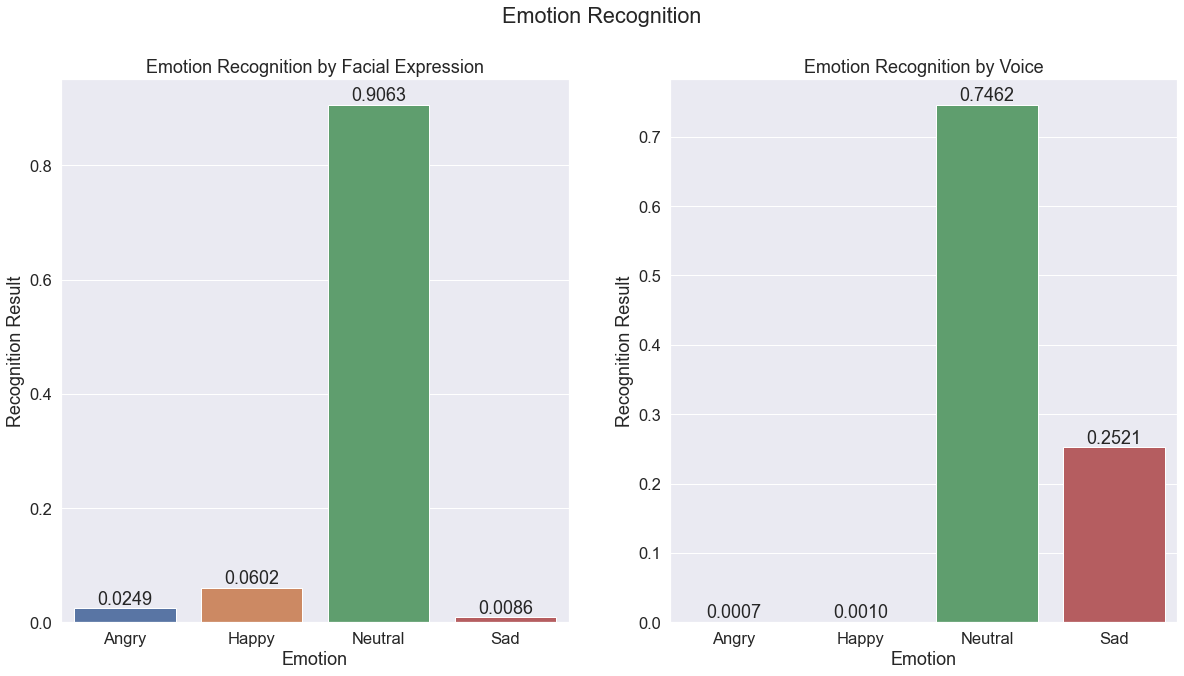

In [32]:
# For Instant Result Viewing
if len(employeeList) > 1:
    selectEmployee = input()
    for i,id in enumerate(employeeList):
        if id == selectEmployee:
            faceResult = faceResultList[i]
            voiceResult = voiceResultList[i]
else:
    faceResult = faceResultList[0]
    voiceResult = voiceResultList[0]

displayInstantResult(faceResult,voiceResult)

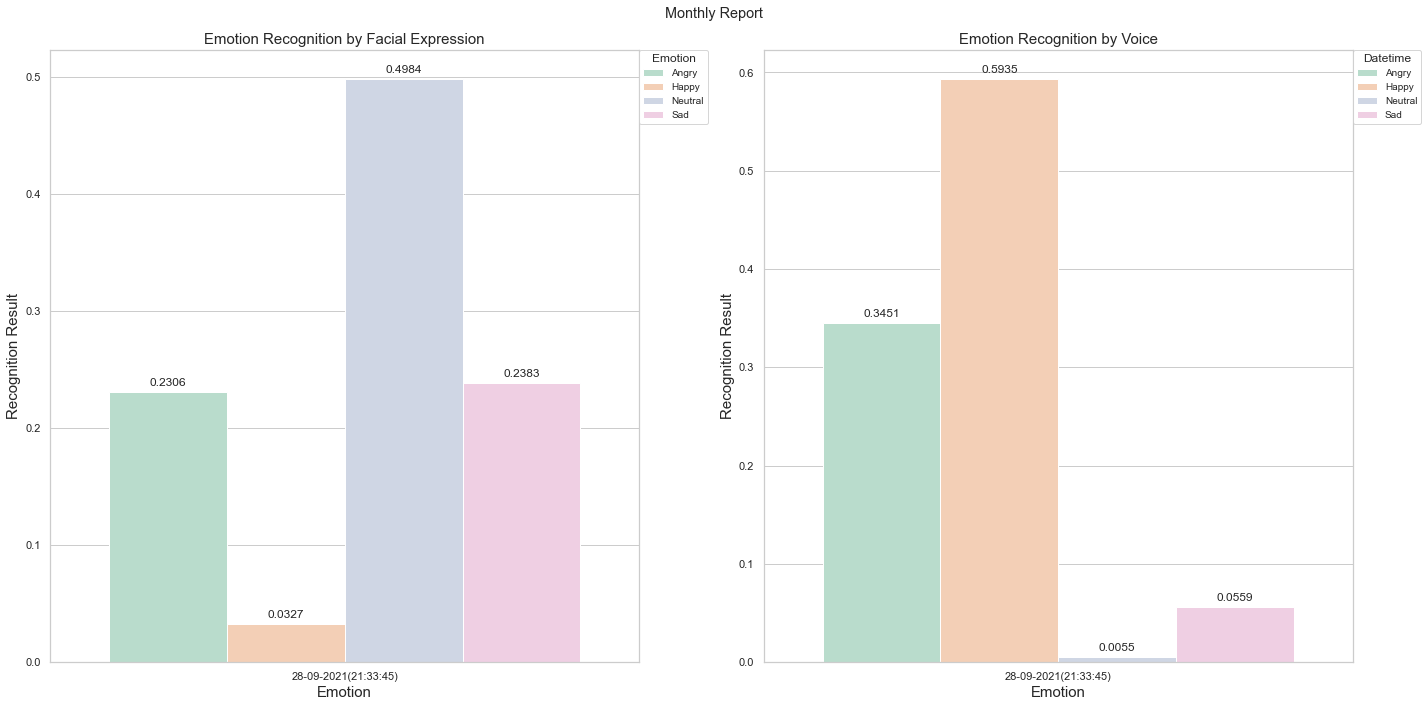

In [15]:
# Monthly Report
dateTimeList,faceResultList,voiceResultList = readResult('E0001',9,2021)
if (len(dateTimeList) > 0):
    dfHistoryGraph = getRecentHistoryDataFrame(dateTimeList,faceResultList,voiceResultList,True)

    displayMonthlyReport(dfHistoryGraph)

In [12]:
# For recent history
dateTimeList,faceResultList,voiceResultList = readResult('E0001')
if (len(dateTimeList) > 0):
    dfHistoryDisplay = getRecentHistoryDataFrame(dateTimeList,faceResultList,voiceResultList,False)

    # import tkinter module
    from tkinter import * 
    from tkinter.ttk import *
    from pandastable import Table

    # creating main tkinter window/toplevel
    master = Tk()

    frame = Frame(master)#, width=1500, height=800
    frame.pack(fill='both', expand=True)
    pt = Table(frame, dataframe=dfHistoryDisplay, editable=False,width=1000,height=500)
    pt.cellwidth = 200
    pt.show()

    mainloop()